In [11]:
# ensure relative imports are correct
import sys
sys.path.insert(0, '../..') # this notebook resides in a sub-sub-directory in the main package

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.QuantumMachine import QuantumMachine
from qm.qua import *

from instruments import LabBrick, MetaInstrument, Sa124
from instruments.quantum_machines.configuration import *

from measurements.routines import resonator_spectroscopy
from measurements.routines import resonator_power_level
from measurements.routines import qubit_spectroscopy
from measurements.routines import power_rabi
from measurements.routines import qubit_T1

In [4]:
# define a qubit
class Qubit(MetaInstrument):
    """
    Encapsulates a qubit.
    """
    def __init__(self, name: str, lo_freq: float):
        self.name = name
        self.lo_freq = lo_freq
    
    def _create_parameters(self):
        print("created dummy parameters for " + self.name)
    
    def _create_yaml_map(self):
        return {
            'lo_freq': self.lo_freq
        }

# instantiate the qubit
qubit = Qubit(name='qubit', lo_freq=4.36e9)

In [5]:
# define a resonator
class Resonator(MetaInstrument):
    """
    Encapsulates a resonator.
    """
    def __init__(self, name: str, lo_freq: float):
        self.name = name
        self.lo_freq = lo_freq
    
    def _create_parameters(self):
        print("created dummy parameters for " + self.name)
    
    def _create_yaml_map(self):
        return {
            'lo_freq': self.lo_freq
        }

# instantiate the resonator
rr = Resonator(name='rr', lo_freq=8.7571e9)

In [6]:
# start the qm
qmm = QuantumMachinesManager()
qm = qmm.open_qm(config)

2021-04-17 12:16:33,019 - qm - INFO - Performing health check
2021-04-17 12:16:33,026 - qm - INFO - Health check passed


In [7]:
# We have tuned the IQ mixer according to the tutorial-2-2-SA124B-MixerTuning.ipynb document.
# These are key numbers obtained:
rr_dcOffsetI = 0.011558358245951837
rr_dcOffsetQ = -0.00947436793762317
rr_mixerGainCorrection = -0.15430981633780644
rr_mixerPhaseCorrection = 0.0212698142172309

q_dcOffsetI = -0.00647755186574999 
q_dcOffsetQ = -0.011624171790995147
q_mixerGainCorrection = -0.19547425898369505
q_mixerPhaseCorrection = 0.05154287262922243

# after this step we have tuned the IQ mixer.
qm.set_output_dc_offset_by_element("rr", "I", float(rr_dcOffsetI)) 
qm.set_output_dc_offset_by_element("rr", "Q", float(rr_dcOffsetQ))
qm.set_mixer_correction("mixer_rr", rr_IF, rr_LO, IQ_imbalance(rr_mixerGainCorrection, rr_mixerPhaseCorrection))
qm.set_output_dc_offset_by_element("qubit", "I", float(q_dcOffsetI)) 
qm.set_output_dc_offset_by_element("qubit", "Q", float(q_dcOffsetQ))
qm.set_mixer_correction("mixer_qubit", qubit_IF, qubit_LO, IQ_imbalance(rr_mixerGainCorrection, q_mixerPhaseCorrection))

In [8]:
# start the labbricks
lb_q = LabBrick(name='lb_q', serial_number=25331, element=qubit, power=15)
lb_rr = LabBrick(name='lb_rr', serial_number=25337, element=rr, power=13)

Trying to initialize lb_q
Connnected to LabBrick 25331
creating parameters...
Initializing device...
Successfully set frequency to 4.36E+09
Successfully set power to +15
Trying to initialize lb_rr
Connnected to LabBrick 25337
creating parameters...
Initializing device...
Successfully set frequency to 8.76E+09
Successfully set power to +13


In [94]:
with program() as script:
    play('CW', 'rr')
qm.execute(script)

2021-04-13 21:06:22,390 - qm - INFO - Flags: 
2021-04-13 21:06:22,390 - qm - INFO - Executing high level program


In [34]:
with program() as tof_cal:

    adc_st = declare_stream(adc_trace=True)
    n = declare(int)
    
    
with for_(n, 0, n < 1000, n + 1):
        reset_phase("rr")
        play('CW'*amp(1.2), 'qubit')
        measure("long_readout"*amp(1), "rr", adc_st)
        wait(25, "rr")
    
    with stream_processing(): 
        adc_st.input1().average().save('adc_mem')

In [35]:
job = qm.execute(tof_cal)

2021-04-13 21:41:22,257 - qm - INFO - Flags: 
2021-04-13 21:41:22,257 - qm - INFO - Executing high level program


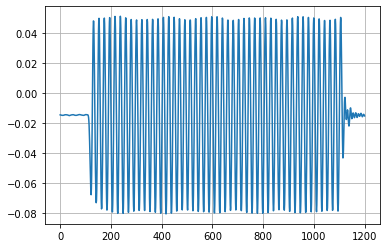

In [36]:
res_handles = job.result_handles
adc_handle = res_handles.get('adc_mem')
plt.plot(adc_handle.fetch_all() /2**12)
plt.grid()

In [37]:
job.halt()

True

In [93]:
with program() as script:

    #I_st = declare_stream()
    #Q_st = declare_stream()
    
    #update_frequency("rr", rr_frequency)
    with infinite_loop_():
        play('gaussian', 'qubit', duration = int(145))
        #align('rr', 'qubit')
        wait(int(15e3), 'rr')
        #play('CW', 'qubit')
    #align('qubit', 'rr')
    #measure("long_readout" * amp(a), "rr", None, demod.full('long_integW1', I), demod.full('long_integW2', Q))
    #wait(WAIT_TIME, "rr")

    #with stream_processing():
    #    I_st.buffer(len(AMP_VEC)).average().save('I_mem')
    #    Q_st.buffer(len(AMP_VEC)).average().save('Q_mem')
    
qua_script = script
queued_job = qm.queue.add(qua_script)

2021-04-13 21:06:16,856 - qm - INFO - Flags: 
2021-04-13 21:06:16,857 - qm - INFO - Executing high level program


In [25]:
queued_job.cancel()

False

In [70]:
with program() as script:
    
    n = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    
    with for_(n, 0, n < 400000, n + 1):
        measure("long_readout", "rr", None, demod.full('long_integW1', I), demod.full('long_integW2', Q))
        save(I, I_st)
        save(Q, Q_st)
        wait(int(1e3), 'rr')
        
    with stream_processing():
        I_st.buffer(2,2).average().save_all('I_mem')
        Q_st.buffer(2,2).average().save_all('Q_mem')
    
qua_script = script
queued_job = qm.queue.add(qua_script)
print(queued_job.id())

2021-04-16 02:03:53,948 - qm - INFO - Flags: 
2021-04-16 02:03:53,949 - qm - INFO - Executing high level program
1618563830102


In [74]:
a = None

In [79]:
b = True if a.a() else False

AttributeError: 'NoneType' object has no attribute 'a'

In [78]:
b

True

In [71]:
queued_job.position_in_queue()

1

In [72]:
queued_job.cancel()

True

In [73]:
queued_job.position_in_queue()

In [33]:
job = queued_job.wait_for_execution()
res_handles = job.result_handles
res_handles.wait_for_all_values()

I_handle = res_handles.get('I_mem')
Q_handle = res_handles.get('Q_mem')

#I_list = I_handle.fetch_all()
#Q_list = Q_handle.fetch_all()

In [10]:
list(I_handle.fetch_all(flat_struct=True))

[array([[-1.24443322e-04, -1.07612461e-04],
        [-7.97361135e-05, -1.01335347e-04]]),
 array([[-1.16471201e-04, -1.05900690e-04],
        [-8.50986689e-05, -9.84482467e-05]]),
 array([[-1.12757087e-04, -1.05645508e-04],
        [-8.64341855e-05, -1.00035220e-04]]),
 array([[-1.11754984e-04, -1.06865540e-04],
        [-8.45389441e-05, -1.00694597e-04]]),
 array([[-1.12891942e-04, -1.07672066e-04],
        [-8.45260918e-05, -1.00107491e-04]]),
 array([[-1.15226954e-04, -1.07289602e-04],
        [-8.45510513e-05, -9.95788723e-05]]),
 array([[-1.15687826e-04, -1.07710915e-04],
        [-8.37471868e-05, -1.00730253e-04]]),
 array([[-1.15527306e-04, -1.07951928e-04],
        [-8.36378895e-05, -1.00300647e-04]]),
 array([[-1.15777883e-04, -1.08626568e-04],
        [-8.37499069e-05, -1.01234764e-04]]),
 array([[-1.16424635e-04, -1.08805299e-04],
        [-8.27528536e-05, -1.01171807e-04]]),
 array([[-1.16693703e-04, -1.08604065e-04],
        [-8.24809752e-05, -1.00626526e-04]]),
 array([[-

In [36]:
list(I_handle.fetch_all(flat_struct=True))[0]

array([-0.00011043, -0.0001157 ])

In [37]:
list(I_handle.fetch_all(flat_struct=True))[0][1,1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [34]:
Q_handle.fetch_all()

-0.004697132855653763

In [25]:
queued_job.cancel()

False

In [24]:
queued_job.halt

AttributeError: 'QmPendingJob' object has no attribute 'halt'

In [9]:
F_START = -46.0e6
F_STOP = -48.0e6
F_STEP = -0.02e6
rr_f_vec = np.arange(F_START, F_STOP, F_STEP)
reps = 4000
wait_time = 20000
rr_ascale = 0.02

#I_list, Q_list = resonator_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
#                                            rr_amp_scale, qubit_amp_scale = None)

In [10]:
from measurements.routines.resonator_spectroscopy_new import ResonatorSpectroscopy
rr_spec = ResonatorSpectroscopy('rr_spec_1', reps, wait_time, rr_f_vec, rr_ascale)

KeyError: 'Qubit pulse amp. scaling'